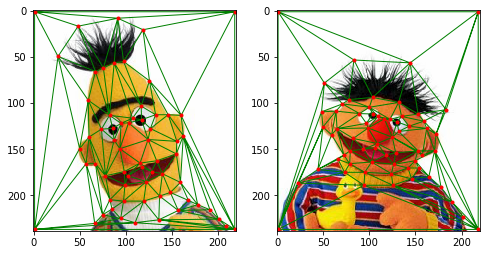

# Face Morphing and Swapping

In this assignment, you will develop a function to warp from one face to another using the piecewise affine warping technique described in class and use it to perform morphing and face-swapping.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

#part 2
from matplotlib.path import Path
from scipy.spatial import Delaunay
from a5utils import bilinear_interpolate

#part 2 demo for displaying animations in notebook
from IPython.display import HTML
from a5utils import display_movie

#part 4 blending
from scipy.ndimage import gaussian_filter

---
# 1. Transforming Triangles [30 pts]

Write a function ***get_transform*** which takes the coorner coordinates of two triangles and computes an affine transformation (represented as a 3x3 matrix) that maps the vertices of a given source triangle to the specified target position. We will use this to map pixels inside each triangle of our mesh. For convenience, you should implement a function ***apply_transform*** that takes a transformation (3x3 matrix) and a set of points, and transforms the points. 

In [2]:
def get_transform(pts_source,pts_target):
    """
    This function takes the coordinates of 3 points (corners of a triangle)
    and a target position and estimates the affine transformation needed
    to map the source to the target location.
    
    
    Parameters
    ----------
    pts_source : 2D float array of shape 2x3
         Source point coordinates
    pts_target : 2D float array of shape 2x3
         Target point coordinates
   
    Returns
    -------
    T : 2D float array of shape 3x3
        the affine transformation
    """
    
    assert(pts_source.shape==(2,3))
    assert(pts_source.shape==(2,3))
    
    # your code goes here  (see lecture #16)
    new_source = np.vstack((pts_source, [1,1,1]))
    new_target = np.vstack((pts_target, [1,1,1]))
    T = np.matmul(new_target, np.linalg.inv(new_source))
    
    return T


def apply_transform(T,pts):
    """
    This function takes the coordinates of a set of points and
    a 3x3 transformation matrix T and returns the transformed
    coordinates
    
    
    Parameters
    ----------
    T : 2D float array of shape 3x3
         Transformation matrix
    pts : 2D float array of shape 2xN
         Set of points to transform
   
    Returns
    -------
    pts_warped : 2D float array of shape 2xN
        Transformed points
    """

    assert(T.shape==(3,3))
    assert(pts.shape[0]==2)
    
    # convert to homogenous coordinates, multiply by T, convert back
    new_pts = np.vstack((pts, np.ones((pts.shape[1]))))
    pts_warped = np.matmul(T, new_pts)[:-1, :]
    
    return pts_warped

In [3]:
#
# Write some test cases for your affine_transform function
#

# check that using the same source and target should yield identity matrix
src = np.array([[1,3,3], [2,3,4]])
targ = np.array([[1,3,3], [2,3,4]])
print(get_transform(src,targ))

# check that if targ is just a translated version of src, then the translation
# appears in the expected locations in the transformation matrix
src = np.array([[1,3,3], [2,3,4]])
targ = np.array([[3,9,9], [4,6,8]])
print(get_transform(src,targ))

# random tests... check that for two random 
# triangles the estimated transformation correctly
# maps one to the other
for i in range(5):
    src = np.random.random((2,3))
    targ = np.random.random((2,3))
    T = get_transform(src,targ)
    targ1 = apply_transform(T,src)
    assert(np.sum(np.abs(targ-targ1))<1e-12)
   

[[  1.00000000e+00  -4.44089210e-16   2.22044605e-16]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[  3.00000000e+00  -1.77635684e-15  -8.88178420e-16]
 [  0.00000000e+00   2.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


---

orig|warped
-|-
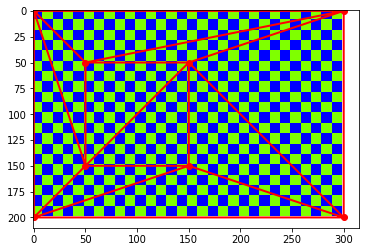 | 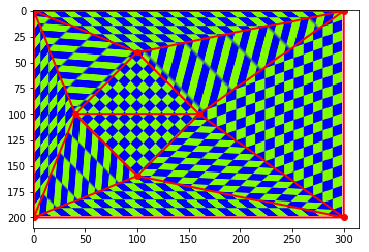

# 2. Piecewise Affine Warping [40 pts]

Write a function called ***warp*** that performs piecewise affine warping of the image. Your function should take a source image, a set of triangulated points in the source image and a set of target locations for those points. We will acomplish this using *backwards warping* in the following steps:

1. For each pixel in the warped output image, you first need to determine which triangle it falls inside of. For this we can use ***matplotlib.path.Path.contains_points*** which checks whether a point falls inside a specified polygon. Your code should build an array ***tindex*** which is the same size as the input image where ***tindex[i,j]=t*** if pixel ***[i,j]*** falls inside triangle ***t***. Pixels which are not in any triangle should have a ***tindex*** value of -1.

2. For each triangle, use your ***get_transform*** function from part 1 to compute the affine transformation which maps the pixels in the output image back to the source image (i.e., mapping pts_target to pts_source for the triangle). Apply the estimated transform to the coordinates of all the pixels in the output triangle to determine their locations in the input image.

3. Use bilinear interpolation to determine the colors of the output pixels. The provided code ***a5utils.py*** contains a function ***bilinear_interpolate*** that implements the interpolation.  To handle color images, you will need to call ***bilinear_interpolate*** three times for the R, G and B color channels separately.


In [4]:

def warp(image,pts_source,pts_target,tri):
    
    """
    This function takes a color image, a triangulated set of keypoints
    over the image, and a set of target locations for those points.
    The function performs piecewise affine wapring by warping the 
    contents of each triangle to the desired target location and 
    returns the resulting warped image.
    
    Parameters
    ----------
    image : 3D float array of shape HxWx3
         An array containing a color image
    
    pts_src: 2D float array of shape 2xN
        Coordinates of N points in the image
        
    pts_target: 2D float array of shape 2xN
        Coorindates of the N points after warping
        
    tri: 2D int array of shape Ntrix3
        The indices of the pts belonging to each of the Ntri triangles
        
    Returns
    -------
    warped_image : 3D float array of shape HxWx3
        resulting warped image
    
    tindex : 2D int array of shape HxW
        array with values in 0...Ntri-1 indicating which triangle 
        each pixel was contained in (or -1 if the pixel is not in any triangle)
    """   

    assert(image.shape[2]==3) #this function only works for color images
    assert(tri.shape[1]==3)   #each triangle has 3 vertices
    assert(pts_source.shape==pts_target.shape)
    assert(np.max(image)<=1)  #image should be float with RGB values in 0..1
    
    ntri = tri.shape[0]
    (h,w,d) = image.shape
    
    # for each pixel in the target image, figure out which triangle
    # it fall in side of so we know which transformation to use for
    # those pixels.
    #
    # tindex[i,j] should contain a value in 0..ntri-1 indicating which
    # triangle contains pixel (i,j).  set tindex[i,j]=-1 if (i,j) doesn't
    # fall inside any triangle
    tindex = -1*np.ones((h,w))
    xx,yy = np.mgrid[0:h,0:w]
    pcoords = np.stack((yy.flatten(),xx.flatten()),axis=1)
    for t in range(ntri):
        corners = np.array([[pts_target[0,tri[t][0]], pts_target[1,tri[t][0]]], 
                            [pts_target[0,tri[t][1]], pts_target[1,tri[t][1]]], 
                            [pts_target[0,tri[t][2]], pts_target[1,tri[t][2]]]])
                            #Vertices of triangle t.  Path expects a Kx2 array of vertices as input
        path = Path(corners)
        mask = path.contains_points(pcoords)
        mask = mask.reshape(h,w)
        #set tindex[i,j]=t any where that mask[i,j]=True
        tindex[mask] = t
        
    # compute the affine transform associated with each triangle that
    # maps a given target triangle back to the source coordinates
    
    Xsource = np.zeros((2,h*w))  #source coordinate for each output pixel
    tindex_flat = tindex.flatten() #flattened version of tindex as an h*w length vector
 
    for t in range(ntri):
        #coordinates of target/output vertices of triangle t
        targ = np.array([ [pts_target[0,tri[t][0]], pts_target[0,tri[t][1]], pts_target[0,tri[t][2]]],
                         [pts_target[1,tri[t][0]], pts_target[1,tri[t][1]], pts_target[1,tri[t][2]]] ])
        
        #coordinates of source/input vertices of triangle t
        psrc = np.array([ [pts_source[0,tri[t][0]], pts_source[0,tri[t][1]], pts_source[0,tri[t][2]]],
                         [pts_source[1,tri[t][0]], pts_source[1,tri[t][1]], pts_source[1,tri[t][2]]] ])  
        
        #compute transform from ptarg -> psrc
        T = get_transform(targ, psrc)
        
        #extract coordinates of all the pixels where tindex==t
        pcoords_t = pcoords[tindex_flat == t]
        pcoords_t = np.array([pcoords_t[:,0], pcoords_t[:,1]])

        #store the transformed coordinates at the correspondiong locations in Xsource
        Xsource[:,tindex_flat==t] = apply_transform(T,pcoords_t)
    
    # now use interpolation to figure out the color values at locations Xsource     
    warped_image = np.zeros(image.shape)
    warped_image[:,:,0] = bilinear_interpolate(image[:,:,0], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    warped_image[:,:,1] = bilinear_interpolate(image[:,:,1], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    warped_image[:,:,2] = bilinear_interpolate(image[:,:,2], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    
    # clip RGB values outside the range [0,1] to avoid warning messages
    # when displaying warped image later on
    warped_image = np.clip(warped_image,0.,1.)

    return (warped_image,tindex)

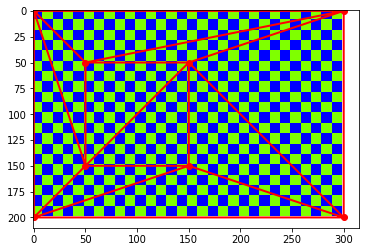

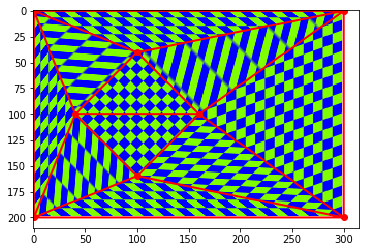

In [5]:
#
# Test your warp function
#

#make a color checkerboard image
(xx,yy) = np.mgrid[1:200,1:300]
G = np.mod(np.floor(xx/10)+np.floor(yy/10),2)
B = np.mod(np.floor(xx/10)+np.floor(yy/10)+1,2)
image = np.stack((0.5*G,G,B),axis=2)

#coordinates of the image corners
pts_corners = np.array([[0,300,300,0],[0,0,200,200]])

#points on a square in the middle + image corners
pts_source = np.array([[50,150,150,50],[50,50,150,150]])
pts_source = np.concatenate((pts_source,pts_corners),axis=1)

#points on a diamond in the middle + image corners
pts_target = np.array([[100,160,100,40],[40,100,160,100]])
pts_target = np.concatenate((pts_target,pts_corners),axis=1)

#compute triangulation using mid-point between source and
#target to get triangles that are good for both.
pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# display initial image
plt.imshow(image)
plt.triplot(pts_source[0,:],pts_source[1,:],tri,color='r',linewidth=2)
plt.plot(pts_source[0,:],pts_source[1,:],'ro')
plt.show()

# display warped image
(warped,tindex) = warp(image,pts_source,pts_target,tri)
plt.imshow(warped)
plt.triplot(pts_target[0,:],pts_target[1,:],tri,color='r',linewidth=2)
plt.plot(pts_target[0,:],pts_target[1,:],'ro')
plt.show()

# display animated movie by warping to weighted averages 
# of pts_source and pts_target

#assemble an array of image frames
movie = []
for t in np.arange(0,1,0.1):
    pts_warp = (1-t)*pts_source+t*pts_target
    warped_image,tindex = warp(image,pts_source,pts_warp,tri)
    movie.append(warped_image)

#use display_movie function defined in a5utils.py to create an animation
HTML(display_movie(movie).to_jshtml())



---
# 3. Face Morphing [15 pts]

Use your warping function in order to generate a morphing video between two faces. A separate notebook ***select_keypoints.ipynb*** has been provided that you can use to click keypoints on a pair of images in order
to specify the correspondences. You should choose two color images of human faces to use (no animals or cartoons) and
use the notebook interface to annotate corresponding keypoints on the two faces. To get a good result you should 
annotate 20-30 keypoints. The images should be centered on the faces with the face taking up most of the image frame.
To keep the code simple, the two images should be the exact same dimension. Please use python or your favorite image editing tool to crop/scale them to the same size before you start annotating keypoints.

Once you have the keypoints saved, modify the code below to load in the keypoints and images, add the
image corners to the set of points, and generate a morph sequence which starts with one face image and smoothly 
transitions to the other face image by simultaneously warping and cross-dissolving between the two.

To generate a frame of the morph at time ***t*** in the interval [0,1], you should: (1) compute the intermediate
shape as a weighted average of the keypoint locations of the two faces, (2) warp both image1 and image2 to this intermediate shape, (3) compute the weighted average of the two warped images.

You will likely want to refer to the code above for testing the ***warp*** function which is closely related.

For grading purposes, your notebook should display

1. The two images with keypoints and triangulations overlayed
2. Three intermediate frames of the morph sequence at t=0.25, t=0.5 and t=0.75


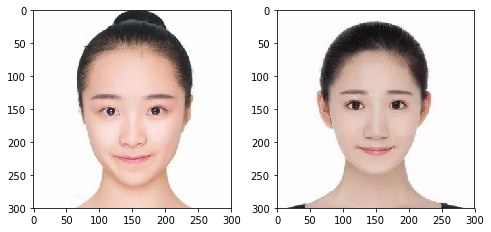

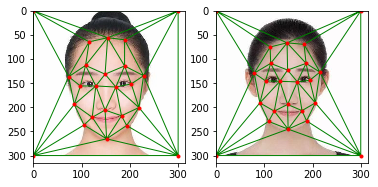

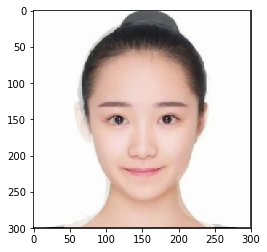

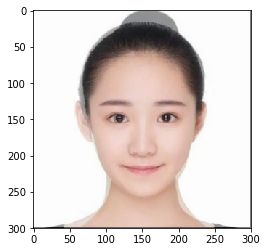

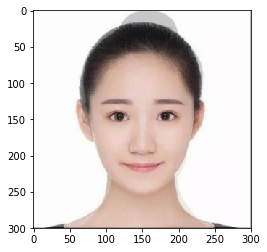

In [6]:
# load in the keypoints and images select_keypoints.ipynb
f = open('face2_correspondeces.pckl','rb')
image1,image2,pts1,pts2 = pickle.load(f)
f.close()

# add the image corners as additional points so that the
# triangles cover the whole image
pts_corners = np.array([[0,300,300,0],[0,0,300,300]])
pts_source = np.concatenate((pts1,pts_corners),axis=1)
pts_target = np.concatenate((pts2,pts_corners),axis=1)

#compute triangulation using mid-point between source and
#target to get trianglest that are good for both.
pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# generate the frames of the morph
movie = []
for t in np.arange(0,1,0.05):
    pts_warp = (1-t)*pts_source+t*pts_target
    warped_image1,tindex1 = warp(image1,pts_source,pts_warp,tri)
    warped_image2,tindex2 = warp(image2,pts_target,pts_warp,tri)
    warped_image= warped_image1*(1-t) + warped_image2*t
    movie.append(warped_image)

# optional: display as an animated movie
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2,2,1).imshow(image1)
fig.add_subplot(2,2,2).imshow(image2)
plt.show() 
    
# display original images and overlaid triangulation
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image1)
ax1.triplot(pts_source[0,:],pts_source[1,:],tri,color='g',linewidth=1)
ax1.plot(pts_source[0,:],pts_source[1,:],'r.')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(image2)
ax2.triplot(pts_target[0,:],pts_target[1,:],tri,color='g',linewidth=1)
ax2.plot(pts_target[0,:],pts_target[1,:],'r.')
plt.show()


# display images at t=0.25, t=0.5 and t=0.75
#   i.e. visualize movie[5], movie[10],movie[15]
fig = plt.figure()
plt.imshow(movie[5])
plt.show()

fig = plt.figure()
fig = plt.figure()
plt.imshow(movie[10])
plt.show()

fig = plt.figure()
fig = plt.figure()
plt.imshow(movie[15])
plt.show()

HTML(display_movie(movie).to_jshtml())

---

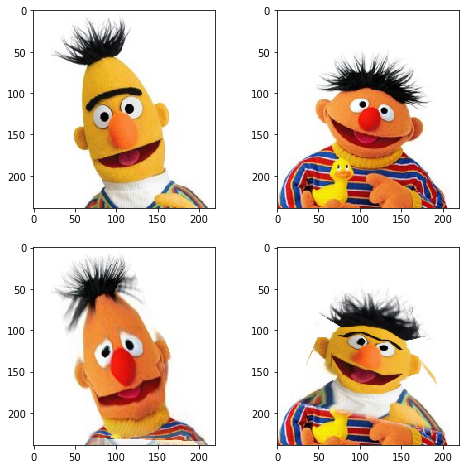

# 4. Face Swapping [15 pts]

We can use the same machinery of piecewise affine warping in order to swap faces.  To accomplish this, we first annotate two faces with keypoints as we did for morphing.  In this case they keypoints should only cover the 
face and we won't add the corners of the image. To place the face from image1 into image2, you should call your
***warp*** function to generate the warped face image1_warped. In order to composite only the warped face pixels,
we need to create an alpha map. You can achieve this by using the ***tindex*** map returned from your warp function
to make a binary mask which is True inside the face region and False else where. In order to minimize visible artifacts, you should utilize ***scipy.ndimage.gaussian_filter*** in order to feather the edge of the alpha mask
(as we did in a previous assignment for panorama mosaic blending). Once you have the feathered alpha map, you can composite the image1_warped face with the background from image2.

You should display in your submitted pdf notebook (1) the two source images with the keypoints overlayed,
(2) the face from image1 overlayed on image2, (3) the face from image2 overlayed on image1.

It is *ok* to use the same faces for this part and the morphing part. However, to get the best results for face swapping it is important to only include keypoints inside the face while for morphing it may be better to include additional keypoints (e.g., in order to morph the hair, clothes etc.)   


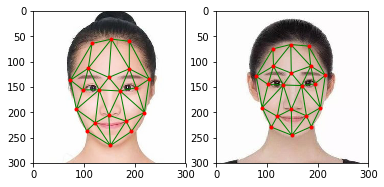

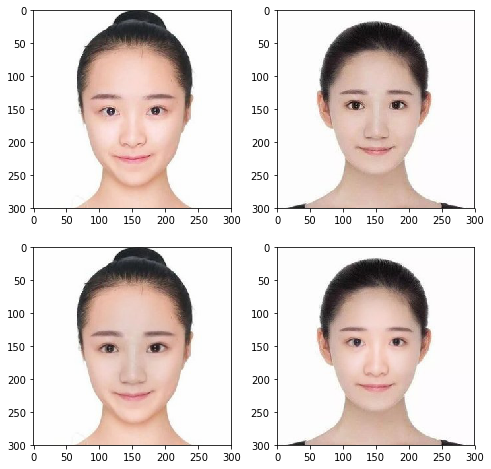

In [7]:
f = open('face2_correspondeces.pckl','rb')
image1,image2,pts1,pts2 = pickle.load(f)
f.close()

#compute triangulation using mid-point between source and
#target to get triangles that are good for both images.
pts_mid = 0.5*(pts2+pts1)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# put the face from image1 in to image2
(warped,tindex) = warp(image1, pts1, pts2, tri)
mask = np.where(tindex == -1, 0, 1)
alpha = gaussian_filter(mask, sigma = 30, output = 'float64') - 0.5
alpha[alpha < 0] = 0
alpha[alpha != 1] -= np.min(alpha[np.nonzero(alpha)])
alpha[alpha < 0] = 0
# alpha=alpha*mask
alpha = np.divide(alpha, np.max(alpha))
swap1 = np.zeros(image1.shape)
# do an alpha blend of the warped image1 and image2
swap1[:,:,0] = alpha * warped[:,:,0] + (np.ones(alpha.shape) - alpha) * image2[:, :, 0]
swap1[:,:,1] = alpha * warped[:,:,1] + (np.ones(alpha.shape) - alpha) * image2[:, :, 1]
swap1[:,:,2] = alpha * warped[:,:,2] + (np.ones(alpha.shape) - alpha) * image2[:, :, 2]

#now do the swap in the other direction
(warped,tindex) = warp(image2, pts2, pts1, tri)
mask = np.where(tindex == -1, 0, 1)
alpha = gaussian_filter(mask, sigma = 30, output = 'float64') - 0.5
alpha[alpha < 0] = 0
alpha[alpha != 1] -= np.min(alpha[np.nonzero(alpha)]) 
alpha[alpha < 0] = 0
# alpha=alpha*mask 
alpha = np.divide(alpha, np.max(alpha))
swap2 = np.zeros(image1.shape)
swap2[:,:,0] = alpha * warped[:,:,0] + (np.ones(alpha.shape) - alpha) * image1[:, :, 0]
swap2[:,:,1] = alpha * warped[:,:,1] + (np.ones(alpha.shape) - alpha) * image1[:, :, 1]
swap2[:,:,2] = alpha * warped[:,:,2] + (np.ones(alpha.shape) - alpha) * image1[:, :, 2]

# display the images with the keypoints overlayed
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image1)
ax1.triplot(pts1[0,:],pts1[1,:],tri,color='g',linewidth=1)
ax1.plot(pts1[0,:],pts1[1,:],'r.')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(image2)
ax2.triplot(pts2[0,:],pts2[1,:],tri,color='g',linewidth=1)
ax2.plot(pts2[0,:],pts2[1,:],'r.')
plt.show()

# display the face swapping result
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2,2,1).imshow(image1)
fig.add_subplot(2,2,2).imshow(image2)
fig.add_subplot(2,2,3).imshow(swap2)
fig.add_subplot(2,2,4).imshow(swap1)
plt.show()
